In [74]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph
import statistics
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from umap import UMAP  
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import pearsonr

In [75]:
D_data = pd.read_csv('data/Denmark/Merged.csv')
USA_data = pd.read_csv('data/USA/filtered_USA_votes.csv')

In [76]:
D_data['opdateringsdato_x'] = pd.to_datetime(D_data['opdateringsdato_x'],errors='coerce')

start_date = "2022-12-01"
end_date = "2025-12-31"

D_data = D_data[(D_data['opdateringsdato_x'] >= start_date) & (D_data['opdateringsdato_x'] <= end_date)]

In [77]:
D_data

,Unnamed: 0,typeid_x,afstemningid,aktørid,opdateringsdato_x,id_y,typeid_y,navn,opdateringsdato_y,startdato,slutdato,party
1672,1672,1,9004,49,2022-12-13 13:01:44.197,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1673,1673,1,9014,49,2022-12-22 09:42:26.073,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1674,1674,1,9015,49,2022-12-22 09:43:02.663,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1675,1675,1,9016,49,2022-12-22 09:44:07.067,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
1676,1676,1,9017,49,2022-12-22 09:45:39.340,49,5,Erling Bonnesen,2025-02-03T09:39:35.91,2024-10-01T00:00:00,NaN,Venstre
...,...,...,...,...,...,...,...,...,...,...,...,...
302093,302093,1,10110,21044,2025-01-16 17:00:16.147,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302094,302094,1,10111,21044,2025-01-23 10:01:05.520,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302095,302095,1,10112,21044,2025-01-23 10:01:33.953,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet
302096,302096,1,10113,21044,2025-01-23 10:02:11.817,21044,5,Lasse Haugaard Pedersen,2025-02-03T09:39:35.91,2024-12-01T00:00:00,NaN,Socialdemokratiet


In [78]:
#we check both ways, we calc both i -> j and j->i.
# person 221 as i and 1619 as j, and the other way. 1619 as i and 221 as j. is that a problem? 
#there are prob some variables that needs renaming

def calc_thres(PP, PA, PAV):
    party_agree = []
    for party in PP:
        #print(party)
        memb_agree = []
        for member1 in PP.get(party):
            for member2 in set(PP.get(party)):
                if member1 != member2:
                    common = set(PAV.get(member1)) & set(PAV.get(member2)) # how many votes do they agree on 
                
                    common2 = set(PA.get(member1)) & set(PA.get(member2)) # how many same bills have they voted on

                    if len(common) != 0: # if they have at least one vote thats the same, (too avoid divide by 0)
                    
                        percentage = len(common) / len(common2)
                        memb_agree.append(percentage)
                    else:
                        memb_agree.append(0)
        if len(memb_agree) != 0:
            avgMemb = sum(memb_agree)/len(memb_agree)
            #std_dev = statistics.stdev(memb_agree) if len(memb_agree) > 1 else 0  # Avoid error for single-member case
            avg_plus_std = avgMemb# + std_dev # Compute the sum of average and standard deviation
            party_agree.append(avg_plus_std)
            #print(avg_plus_std)
        #else:
            #print(party) # party where there is only one member
            #print('1')
            #party_agree.append(1)
    avgParty = np.percentile(party_agree, 75)
    #avgParty = sum(party_agree)/len(party_agree)
    #print(max(party_agree))
    return avgParty


In [79]:
def edgelist_calc(PA, PAV, threshold):
    edgelist=[]
    for i in PAV: # person 1

        for j in PAV: # for loop for person 2

            if i != j: # checks they are not the same

                common = set(PAV.get(i)) & set(PAV.get(j)) # how many votes do they agree on 
                
                common2 = set(PA.get(i)) & set(PA.get(j)) # how many same bills have they voted on

                if len(common) != 0: # if they have at least one vote thats the same, (too avoid divide by 0)
                    
                    percentage = len(common) / len(common2)
                    if percentage > threshold:
                        edgelist.append((i,j))
                

    return list(set(edgelist))
    

In [80]:
def calc_inter_edges(PP, PA, PAV):
    inter_party_agree = []  # Stores agreement percentages for different-party members
    parties = list(PP.keys())  # Get the list of parties

    # Take all possible member combinations between the two parties
    party1, party2 = parties[0], parties[1]

    for member1 in PP.get(party1, []):  # Iterate over members of Party 1
        for member2 in PP.get(party2, []):  # Iterate over members of Party 2
            common = set(PAV.get(member1, [])) & set(PAV.get(member2, []))  # Common votes
            common2 = set(PA.get(member1, [])) & set(PA.get(member2, []))  # Common bills

            if len(common) != 0 :  # Avoid division by zero
                percentage = len(common) / len(common2)
                inter_party_agree.append((member1, member2, percentage))
    max_percentage = max(inter_party_agree, key=lambda x: x[2])[2]

    # Get all (member1, member2) pairs with the max percentage
    edgelist = [(m1, m2) for m1, m2, perc in inter_party_agree if perc == max_percentage]

    return edgelist   


In [9]:
#----------------------------------------------------------------------------------------------------------------#
#----------------------------------------DENMARK-----------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------#

In [81]:
#dict, key = id, values = (afstemningid, typeid)
# dict of all people with all their votes (voting id and what they voted)

PA = {}          #<<-------------- Person, Afstemning
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PA:
        PA[row['aktørid']] = [(row['afstemningid'])]
    else:
        PA[row['aktørid']].append((row['afstemningid']))

PAV = {}          #<<-------------- Person, Afstemning, Vote
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PAV:
        PAV[row['aktørid']] = [(row['afstemningid'],row['typeid_x'])]
    else:
        PAV[row['aktørid']].append((row['afstemningid'],row['typeid_x']))


PAVP = {}          #<<-------------- Person, Afstemning, Vote, Party
for idx, row in D_data.iterrows():
    if row['aktørid'] not in PAVP:
        PAVP[row['aktørid']] = [(row['afstemningid'],row['typeid_x'],row['party'],row['navn'])]
    else:
        PAVP[row['aktørid']].append((row['afstemningid'],row['typeid_x'],row['party'],row['navn']))
 
#dict of parties with memberid as values

PP = {}          #<<-------------- Party, Person
for idx, row in D_data.iterrows():
    if row['party'] not in PP:
        PP[row['party']] = [(row['aktørid'])]
    elif row['aktørid'] not in PP.get(row['party']):
        PP[row['party']].append((row['aktørid']))


In [82]:
D_thres = calc_thres(PP,PA,PAV)
D_thres

np.float64(0.9228049426249062)

In [83]:
edgelist = edgelist_calc(PA,PAV, D_thres)
df = pd.DataFrame(edgelist, columns=["Source", "Target"])
df.to_csv("Denmark_edgelist.csv", index=False)
G_denmark = nx.from_edgelist(edgelist)

In [12]:
len(edgelist)

13314

In [13]:
list_of_dangle = [node for node in G_denmark.nodes if G_denmark.degree(node) == 0]
list_of_dangle

[]

In [15]:
#----------------------------------------------------------------------------------------------------------------#
#------------------------------------------USA-------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------#


In [84]:
U_PA = {}          #<<-------------- Person, Afstemning
for idx, row in USA_data.iterrows():
    
    if row['icpsr'] not in U_PA:
        U_PA[row['icpsr']] = [(row['rollnumber'])]
    else:
        U_PA[row['icpsr']].append((row['rollnumber']))

U_PAV = {}          #<<-------------- Person, Afstemning, Vote
for idx, row in USA_data.iterrows():
    
    if row['icpsr'] not in U_PAV:
        U_PAV[row['icpsr']] = [(row['rollnumber'],row['cast_code'])]
    else:
        U_PAV[row['icpsr']].append((row['rollnumber'],row['cast_code']))


U_PAVP = {}          #<<-------------- Person, Afstemning, Vote, Party
for idx, row in USA_data.iterrows():
    if row['icpsr'] not in U_PAVP:
        U_PAVP[row['icpsr']] = [(row['rollnumber'],row['cast_code'],row['party_code'])]
    else:
        U_PAVP[row['icpsr']].append((row['rollnumber'],row['cast_code'],row['party_code']))

#dict of parties with memberid as values

U_PP = {}          #<<-------------- Party, Person
for idx, row in USA_data.iterrows():
    
    if row['party_code'] not in U_PP:
        U_PP[row['party_code']] = [(row['icpsr'])]
    elif row['icpsr'] not in U_PP.get(row['party_code']):
        U_PP[row['party_code']].append((row['icpsr']))

In [85]:
U_thres = calc_thres(U_PP, U_PA, U_PAV)

In [86]:
USA_inter= calc_inter_edges(U_PP,U_PA,U_PAV)

In [87]:
U_edgelist = edgelist_calc(U_PA, U_PAV, U_thres)
U_edgelist = (U_edgelist + USA_inter)
df = pd.DataFrame(U_edgelist, columns=["Source", "Target"])
df.to_csv("USA_edgelist.csv", index=False)
G_USA = nx.from_edgelist(U_edgelist)

In [18]:
list_of_dangle = [node for node in G_USA.nodes if G_USA.degree(node) == 0]
list_of_dangle

[]

In [17]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    100: 0,  # Democrat
    200: 1,  # Republican 
    328: 2,  # Independent
}

for icpsr in U_PAVP:
    party_code = U_PAVP[icpsr][0][2]  # Get party code from first vote
    node_to_community[icpsr] = party_to_community.get(party_code, 3)  # Default 3 for other parties

# Color mapping
community_to_color = {
    0: 'blue',      # Democrats
    1: 'red',       # Republicans
    2: 'green',     # Independents
    3: 'gray'       # Others
}
node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}



c:\Users\kubic\OneDrive\Dokumenty\envs\polarization\lib\site-packages\netgraph\_node_layout.py:1550: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")
c:\Users\kubic\OneDrive\Dokumenty\envs\polarization\lib\site-packages\netgraph\_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


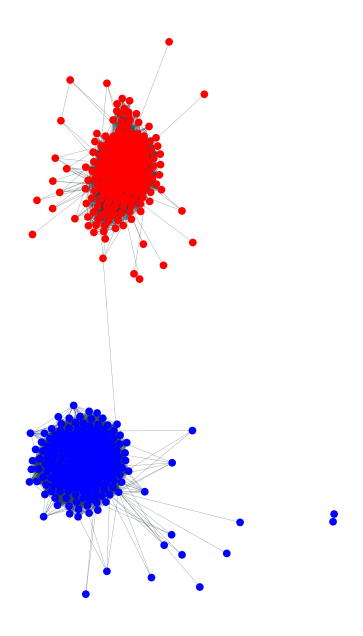

In [18]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_USA,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

In [60]:
set(D_data['party'])

{'Alternativet',
 'Borgernes Parti',
 'Danmarksdemokraterne',
 'Dansk Folkeparti',
 'Det Konservative Folkeparti',
 'Enhedslisten',
 'Liberal Alliance',
 'Moderaterne',
 'Radikale Venstre',
 'Sambandsflokkurin',
 'Siumut',
 'Socialdemokratiet',
 'Socialistisk Folkeparti',
 'Uden for folketingsgrupperne',
 'Venstre'}

In [61]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    'Alternativet': 0,  
    'Danmarksdemokraterne': 1,   
    'Dansk Folkeparti': 2,
    'Det Konservative Folkeparti': 3,
    'Enhedslisten': 4,
    'Frie Grønne': 5,
    'Liberal Alliance': 6,
    'Moderaterne': 7,
    'Radikale Venstre': 8,
    'Sambandsflokkurin': 9,
    'Siumut': 10,
    'Socialdemokratiet': 11,
    'Socialistisk Folkeparti': 12,
    'Uden for folketingsgrupperne': 13,
    'Venstre': 14,
     

}

# Color mapping
community_to_color = {
   0: 'green',
   1: 'lightblue', 
   2: 'yellow',
   3: 'darkgreen',
   4: 'orange',
   5: 'cyan',
   6: 'blue',
   7: 'magenta',
   8: 'purple',
   9: 'black',
   10: 'gray',
   11: 'red',
   12: 'pink',
   13: 'brown',
   14: 'navy'
}

node_to_community = {}
for aktor_id in PAVP:
   party_name = PAVP[aktor_id][0][2]  # Get party name from first vote
   node_to_community[aktor_id] = party_to_community.get(party_name, 0)

node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}

c:\Users\kubic\OneDrive\Dokumenty\envs\polarization\lib\site-packages\netgraph\_node_layout.py:1621: UserWarning: There are no connections within community 13. The placement of of nodes within this community is arbitrary.
  warnings.warn(f"There are no connections within community {community}. The placement of of nodes within this community is arbitrary.")


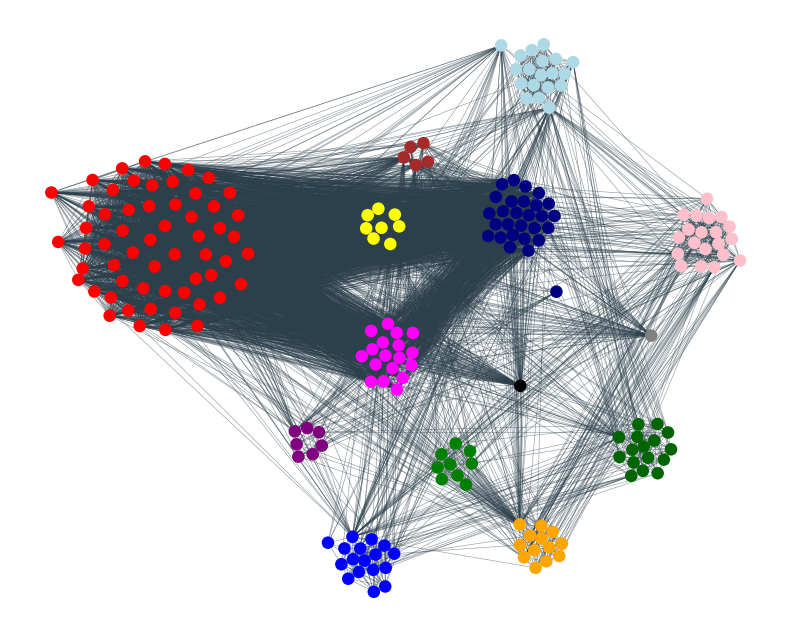

In [62]:
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_denmark,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

## PCA DK

In [19]:
# Step 1: Create a list of people (rows) and their corresponding voted bills (columns)
people = list(PAV.keys())  # List of people (1, 2, 3, 4)
votes = set()  # Store the distinct votes/bills
for person in PAV:
    votes.update(PAV[person])  # Add all the bills that each person voted on

votes = sorted(votes)  # Sort the bills to get a consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the data for the sparse matrix
data = []
row_indices = []
col_indices = []

for person, voted_bills in PAV.items():
    for bill in voted_bills:
        row_indices.append(people.index(person))  # Person's row index
        col_indices.append(vote_to_index[bill])   # Bill's column index
        data.append(1)  # The value in the matrix is 1 if the person voted on the bill

# Step 3: Create the sparse matrix (CSR format)
num_people = len(PAV)  # Number of people
num_votes = len(votes)  # Number of bills
sparse_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(num_people, num_votes))



In [18]:
# Step 2: Apply TruncatedSVD (PCA for sparse matrix)
n_components = 1  # You can set the number of components (dimensions) to reduce to
svd = TruncatedSVD(n_components=n_components)
D_reduced_matrix = svd.fit_transform(sparse_matrix)

# Step 3: Display the reduced matrix (lower dimensions)
print("Reduced Matrix (PCA Result):")
print(D_reduced_matrix)

# Optional: You can also check the amount of variance explained by each component
print("Explained variance ratio:")
print(svd.explained_variance_ratio_)

Reduced Matrix (PCA Result):
[[2.61807893e+01]
 [1.89413909e+01]
 [2.12960135e+01]
 [3.99366512e-01]
 [1.40611107e+01]
 [1.16608527e+01]
 [3.64484277e+00]
 [1.60212661e+01]
 [2.44524799e+01]
 [2.39593585e+01]
 [1.98070764e+01]
 [2.07538955e+01]
 [1.74740736e+01]
 [2.46280749e+00]
 [2.43938454e+01]
 [1.88244921e+01]
 [2.72507283e+01]
 [2.62279419e+01]
 [1.76026875e+01]
 [1.09371578e+01]
 [1.35896230e+01]
 [1.32526023e+01]
 [2.76467672e+01]
 [2.22595848e+01]
 [2.12648638e+01]
 [2.29362220e+01]
 [1.29788040e+01]
 [7.52900047e+00]
 [2.81376103e+01]
 [4.49608017e-01]
 [1.85251029e+01]
 [1.63008916e+01]
 [1.63788834e+01]
 [1.86005520e+01]
 [1.20810433e+00]
 [1.80608070e+01]
 [1.45009213e+01]
 [6.51112244e+00]
 [6.97480627e+00]
 [1.58216082e+01]
 [1.55091522e+01]
 [1.73734881e+01]
 [1.92692395e+01]
 [2.84384307e+01]
 [9.94907129e+00]
 [1.58384805e+01]
 [3.89997135e-01]
 [1.33641199e+01]
 [1.19194509e+00]
 [6.44388052e+00]
 [2.11013870e+01]
 [2.32891018e+01]
 [5.36483474e+00]
 [1.35392568e+01]

In [19]:
D_standard_reduced_matrix = (D_reduced_matrix-min(D_reduced_matrix))/(max(D_reduced_matrix)-min(D_reduced_matrix))
D_standard_reduced_matrix

array([[8.76530297e-01],
       [6.34050367e-01],
       [7.12917240e-01],
       [1.29947844e-02],
       [4.70587888e-01],
       [3.90192481e-01],
       [1.21700345e-01],
       [5.36242285e-01],
       [8.18641463e-01],
       [8.02124614e-01],
       [6.63046058e-01],
       [6.94759277e-01],
       [5.84903328e-01],
       [8.21086801e-02],
       [8.16677528e-01],
       [6.30134902e-01],
       [9.12367354e-01],
       [8.78109650e-01],
       [5.89211184e-01],
       [3.65952690e-01],
       [4.54795648e-01],
       [4.43507314e-01],
       [9.25632473e-01],
       [7.45191567e-01],
       [7.11873897e-01],
       [7.67855181e-01],
       [4.34336580e-01],
       [2.51798211e-01],
       [9.42073011e-01],
       [1.46775978e-02],
       [6.20107015e-01],
       [5.45608198e-01],
       [5.48220496e-01],
       [6.22634141e-01],
       [4.00830423e-02],
       [6.04555662e-01],
       [4.85319118e-01],
       [2.17704910e-01],
       [2.33235761e-01],
       [5.29554849e-01],


## PCA US

In [ ]:
from scipy.sparse import csr_matrix

# Step 1: Extract unique people (rows) and bills (columns)
people = list(U_PAV.keys())  # List of people
votes = set()  # Store the distinct votes/bills

for voted_bills in U_PAV.values():
    for bill, _ in voted_bills:
        votes.add(bill)

votes = sorted(votes)  # Sort bills for consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the sparse matrix data
data = []
row_indices = []
col_indices = []

for person, voted_bills in U_PAV.items():
    for bill, vote in voted_bills:  # Iterate over (bill, vote) pairs
        if vote == 1:
            value = 0  # Vote 1 → 0
        elif vote == 2:
            value = 1  # Vote 2 → 1
        else:
            continue  # Skip non-voted bills

        row_indices.append(people.index(person))  # Person's row index
        col_indices.append(vote_to_index[bill])  # Bill's column index
        data.append(value)  # Store transformed vote value

# Step 3: Create the sparse matrix (CSR format)
num_people_us = len(U_PAV)  # Number of people
num_votes_us = len(votes)  # Number of bills
sparse_matrix_us = csr_matrix((data, (row_indices, col_indices)), shape=(num_people_us, num_votes_us))



Sparse Matrix (CSR format):
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 516591 stored elements and shape (451, 1235)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	0
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	0
  (0, 13)	0
  (0, 14)	0
  (0, 15)	0
  (0, 16)	0
  (0, 17)	1
  (0, 18)	0
  (0, 19)	0
  (0, 20)	1
  (0, 21)	0
  (0, 22)	1
  (0, 23)	0
  (0, 24)	0
  :	:
  (450, 1210)	0
  (450, 1211)	0
  (450, 1212)	0
  (450, 1213)	0
  (450, 1214)	0
  (450, 1215)	0
  (450, 1216)	0
  (450, 1217)	0
  (450, 1218)	0
  (450, 1219)	0
  (450, 1220)	0
  (450, 1221)	0
  (450, 1222)	0
  (450, 1223)	0
  (450, 1224)	0
  (450, 1225)	1
  (450, 1226)	0
  (450, 1227)	0
  (450, 1228)	0
  (450, 1229)	0
  (450, 1230)	0
  (450, 1231)	0
  (450, 1232)	0
  (450, 1233)	0
  (450, 1234)	0

Dense Matrix (for verification):
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [128]:
# Step 2: Apply TruncatedSVD (PCA for sparse matrix)
n_components = 2  # You can set the number of components (dimensions) to reduce to
pca = PCA(n_components=n_components)
US_reduced_matrix= pca.fit_transform(sparse_matrix_us)

# Step 3: Display the reduced matrix (lower dimensions)
print("Reduced Matrix (PCA Result):")
print(US_reduced_matrix)

# Optional: You can also check the amount of variance explained by each component
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

Reduced Matrix (PCA Result):
[[-9.48317463e+00  7.71314775e+00]
 [-1.03954415e+01  4.98891539e+00]
 [ 1.39571950e+01  2.54658020e-01]
 [ 1.28743114e+01  1.09231664e+00]
 [ 1.44808664e+01 -3.67647124e-01]
 [ 1.29768815e+01 -1.42709429e+00]
 [ 1.45721711e+01 -3.21567781e-01]
 [ 1.46745250e+01 -3.32448287e-01]
 [ 1.39762295e+01  2.60115443e-01]
 [-1.24008263e+01  2.43627151e+00]
 [ 1.37659704e+01  2.19804989e-01]
 [ 1.49883704e+01 -3.85597143e-01]
 [-1.25589639e+01  2.08798305e+00]
 [-1.32464534e+01  7.94430732e-01]
 [ 1.34495075e+01 -1.36610762e+00]
 [-1.19314809e+01  4.01461297e+00]
 [ 7.26216451e+00 -1.63998035e+00]
 [ 1.47484293e+01 -4.74903891e-01]
 [-9.53931053e+00  7.08049284e+00]
 [ 1.32686347e+01  9.28653540e-01]
 [ 1.37895173e+01  8.84172030e-01]
 [ 1.33108413e+01 -9.04987318e-01]
 [-8.80090895e+00  6.75624751e+00]
 [-9.19587900e+00  8.15693493e+00]
 [-1.36214489e+01 -1.42622860e+00]
 [-1.18372685e+01  1.68127511e+00]
 [ 1.16881578e+01  1.47784028e+00]
 [ 1.43122536e+01  6.39512

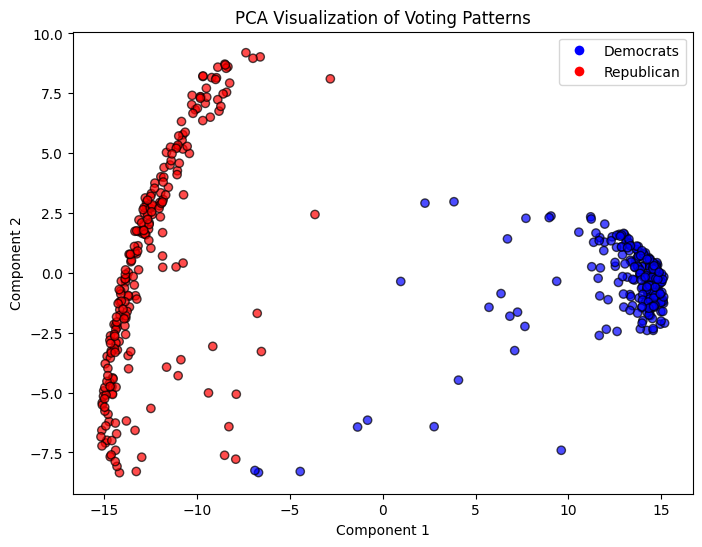

In [129]:
# Step 3: Get Party Information
person_to_party = {person: party for party, members in U_PP.items() for person in members}
party_colors = {100: 'blue', 200: 'red'}  # Assign colors

# Assign colors based on party
colors = [party_colors.get(person_to_party.get(person, -1), 'gray') for person in people]

# Step 4: Plot the Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(US_reduced_matrix[:, 0], US_reduced_matrix[:, 1], c=colors, alpha=0.7, edgecolors='k')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA Visualization of Voting Patterns")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrats'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican')])
plt.show()

In [180]:
people_array = np.array(people)

# Step 2: Get Boolean masks for Democrats and Republicans
democrat_mask = np.array([person_to_party.get(person, -1) == 100 for person in people])
republican_mask = np.array([person_to_party.get(person, -1) == 200 for person in people])

# Step 3: Extract PCA values
democrats_pca = US_reduced_matrix[democrat_mask]
republicans_pca = US_reduced_matrix[republican_mask]

# Step 4: Print the shape of extracted matrices
print(f"Democrats PCA Shape: {democrats_pca.shape}")
print(f"Republicans PCA Shape: {republicans_pca.shape}")

Democrats PCA Shape: (221, 2)
Republicans PCA Shape: (230, 2)


In [ ]:
pc1 = US_reduced_matrix[:,0]
pc2 = US_reduced_matrix[:,1]

demo_pc1 = democrats_pca[:,0]
demo_pc2 = democrats_pca[:,1]

repo_pc1 = republicans_pca[:,0]
repo_pc2 = republicans_pca[:,1]

In [184]:
cand = pd.read_csv("data/USA/H118_members.csv")

nom1 = cand["nominate_dim1"]
nom2 = cand["nominate_dim2"]

demo = cand[cand['party_code']==100]
repo = cand[cand['party_code']==200]


demo_nom1 = demo["nominate_dim1"]
demo_nom2 = demo['nominate_dim2']


repo_nom1 = repo["nominate_dim1"]
repo_nom2 = repo['nominate_dim2']


In [188]:
corr_score, p_value = pearsonr(pc1, nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(pc2, nom2)
print(corr_score, p_value)

0.09403432987478791 0.04594840771682506
0.0423141538163003 0.36997332080179074


In [185]:
corr_score, p_value = pearsonr(demo_pc1, demo_nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(demo_pc2, demo_nom2)
print(corr_score, p_value)

0.08208607248887716 0.224202410206411
0.013233733192250772 0.8449025162910712


In [ ]:
corr_score, p_value = pearsonr(repo_pc1, repo_nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(repo_pc2, repo_nom2)
print(corr_score, p_value)

0.14022604355542503 0.03353993444487238
-0.04079216197904792 0.5382051546444928


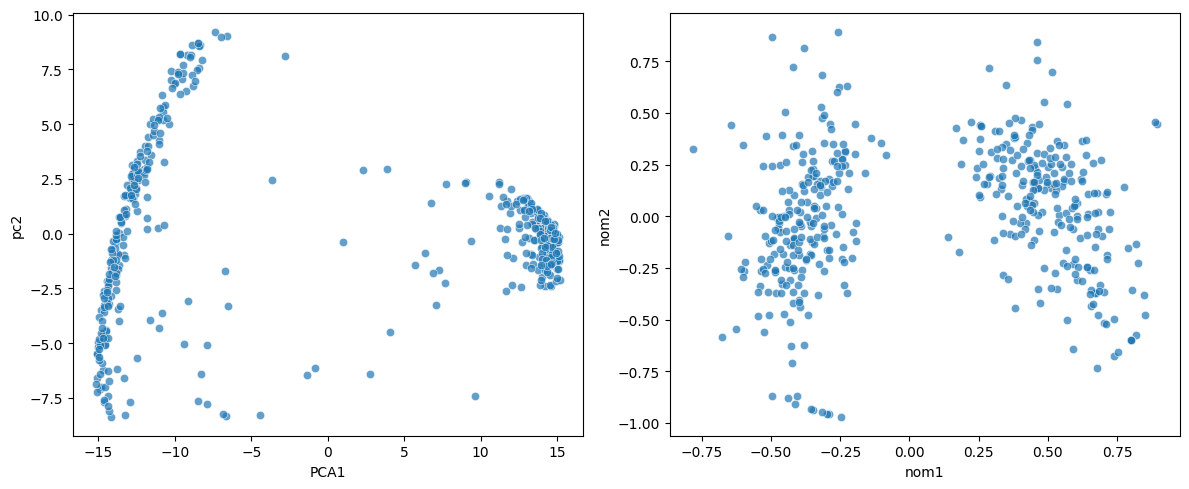

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=pc1, y=pc2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("pc2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=nom1, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("nom1")
axes[1].set_ylabel("nom2")


plt.tight_layout()
plt.show()


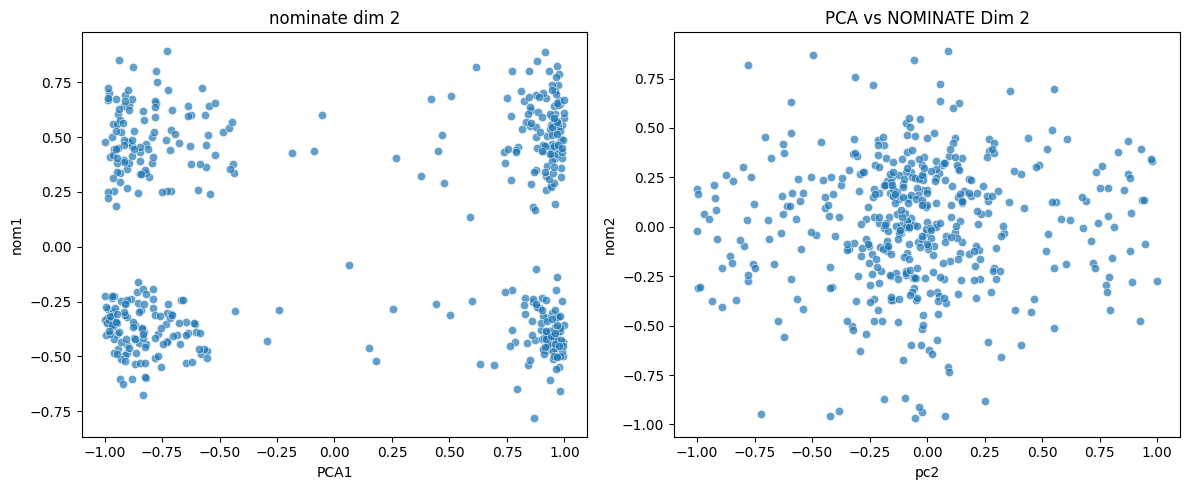

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=pc1, y=nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=pc2, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

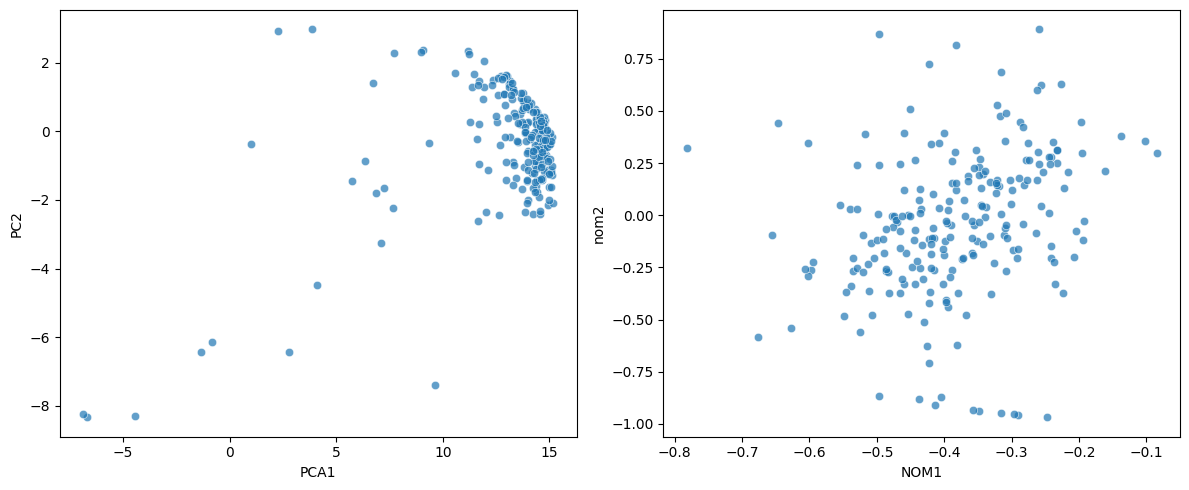

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=demo_pc1, y=demo_pc2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("PC2")


# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=demo_nom1, y=demo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("NOM1")
axes[1].set_ylabel("nom2")

plt.tight_layout()
plt.show()

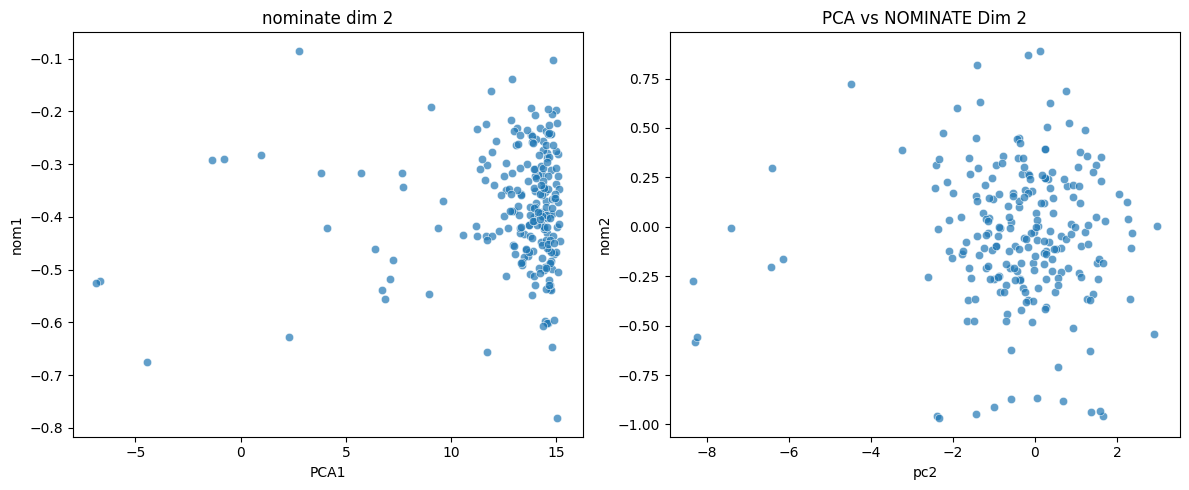

In [193]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=demo_pc1, y=demo_nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=demo_pc2, y=demo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

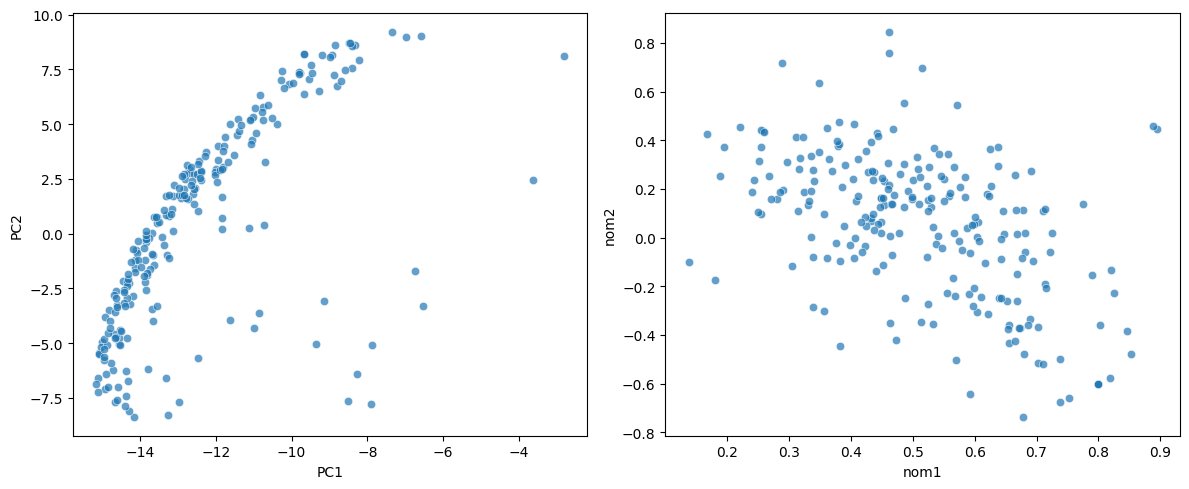

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=repo_pc1, y=repo_pc2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=repo_nom1, y=repo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("nom1")
axes[1].set_ylabel("nom2")

plt.tight_layout()
plt.show()

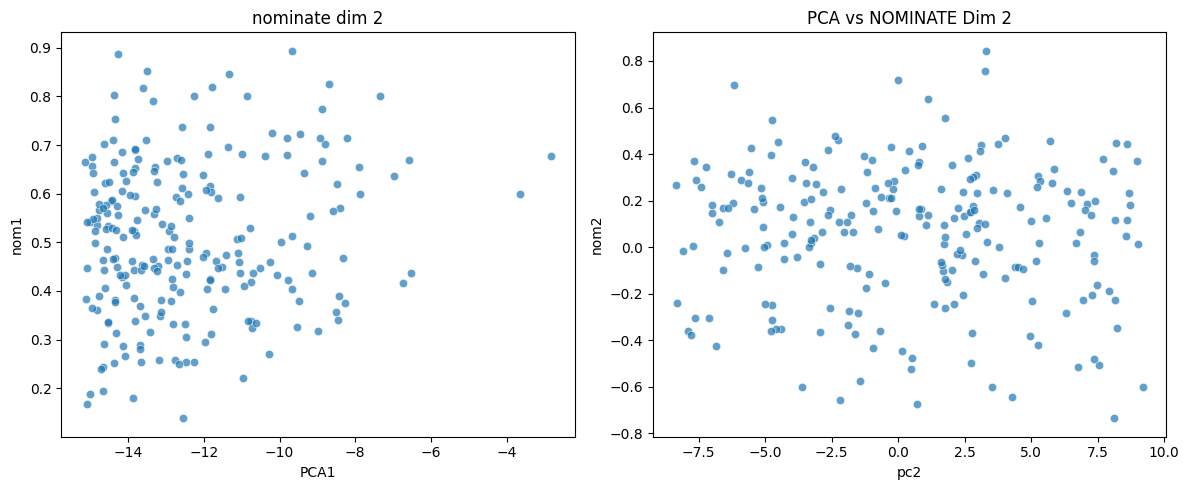

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=repo_pc1, y=repo_nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=repo_pc2, y=repo_nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

In [156]:
# Create UMAP model
umap_model = UMAP(n_components=2, random_state=42)  # Changed to uppercase UMAP
umap_result = umap_model.fit_transform(US_reduced_matrix)

/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jonashansen/Documents/ITU/Bachelor_git/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
umap1 = umap_result[:,0]
umap2 = umap_result[:,1]

In [166]:
corr_score, p_value = pearsonr(umap1, nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(umap2, nom2)
print(corr_score, p_value)

0.08918592664588054 0.0584194951536898
0.03167994292709261 0.5021690890843878


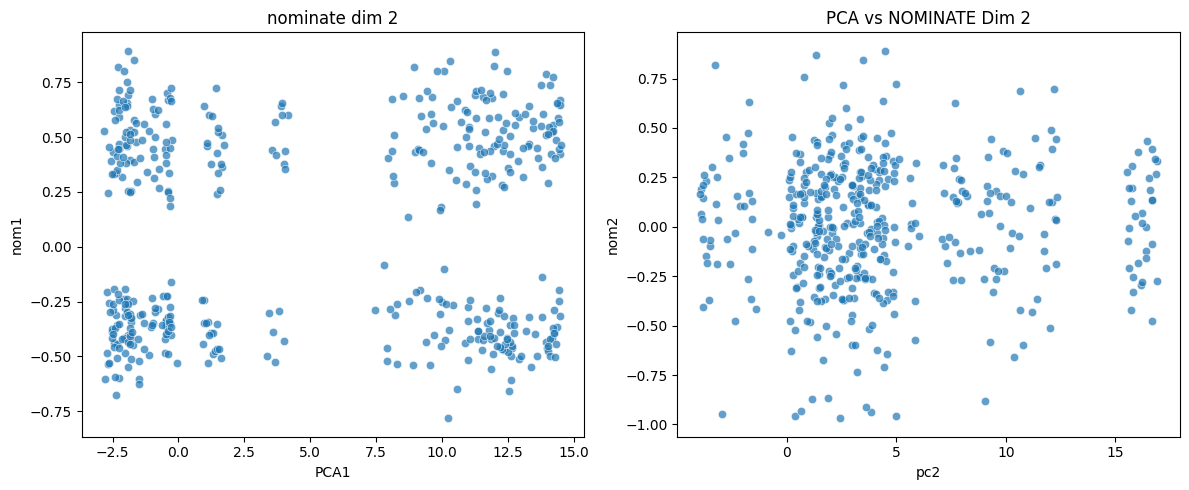

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=umap1, y=nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=umap2, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

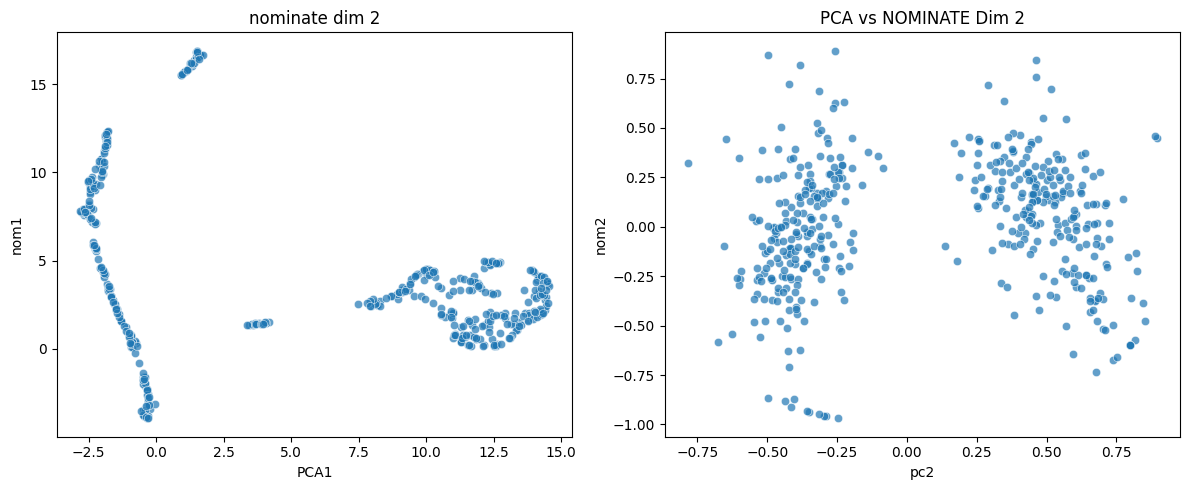

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=umap1, y=umap2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=nom1, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

In [161]:
# Create UMAP model
umap_model = UMAP(n_components=1, random_state=42)  # Changed to uppercase UMAP
umap_result = umap_model.fit_transform(D_reduced_matrix)

umap_result = 2 * (umap_result - np.min(umap_result)) / (np.max(umap_result) - np.min(umap_result)) - 1

# Step 3: Visualize UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_result, np.zeros_like(umap_result), c='blue', label="UMAP Projection")
plt.title("Denmark 1D UMAP Projection After PCA")
plt.xlabel("UMAP Component")
plt.yticks([])  # Hide y-axis ticks since it's 1D
plt.legend()
plt.show()

NameError: name 'D_reduced_matrix' is not defined